# Multi-period OPF example

Multi-period OPF example with and without ESR.

No update on renewable generation and electrification load.

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import nygrid.nygrid as ng_grid
import nygrid.run_nygrid as ng_run
import nygrid.plots as ng_plots

In [2]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid', '2018NewParams')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')
print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

Grid data directory: /mnt/Bo_HDD/NYgrid-python/data/grid/2018NewParams
Figure directory: /mnt/Bo_HDD/NYgrid-python/figures
Results directory: /mnt/Bo_HDD/NYgrid-python/results


## Read grid data

### Read generator profiles

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')
verbose = True

In [4]:
# Read grid property file
grid_prop = ng_run.read_grid_prop(grid_data_dir)

# Read load and generation profiles
grid_profile = ng_run.read_grid_profile(grid_data_dir, start_date.year)

In [ ]:
# Decrease external load by 50%
bus_idx_ext = grid_prop['bus_prop'][grid_prop['bus_prop']['BUS_ZONE'].isin(['NE','PJM','IESO'])]['BUS_I']
load_profile_new = grid_profile['load_profile'].copy()
load_profile_new.loc[:, bus_idx_ext] = load_profile_new.loc[:, bus_idx_ext] * 0.5
grid_profile['load_profile'] = load_profile_new

In [ ]:
# Increase FO2, KER and BIT generation costs
change_index = grid_prop["gen_fuel"]["GEN_FUEL"].isin(
    ["CT_FO2", "CT_KER", "ST_BIT"]
).to_numpy()

gencost0_profile_new = grid_profile['gencost0_profile'].copy()
gencost0_profile_new.loc[:, change_index] = gencost0_profile_new.loc[:, change_index] * 3
grid_profile['gencost0_profile'] = gencost0_profile_new

gencost1_profile_new = grid_profile['gencost1_profile'].copy()
gencost1_profile_new.loc[:, change_index] = gencost1_profile_new.loc[:, change_index] * 3
grid_profile['gencost1_profile'] = gencost1_profile_new

gencost_startup_profile_new = grid_profile['gencost_startup_profile'].copy()
gencost_startup_profile_new.loc[:, change_index] = gencost_startup_profile_new.loc[:, change_index] * 3
grid_profile['gencost_startup_profile'] = gencost_startup_profile_new

## Multi-period OPF

### Without initial conditions

In [8]:
# Only run for one day
d = 0
start_datetime_0 = timestamp_list[d]
# end_datetime_0 = start_datetime_0 + timedelta(hours=24*364+23)
end_datetime_0 = start_datetime_0 + timedelta(hours=24*7+23)
print(f'Start time: {start_datetime_0}')
print(f'End time: {end_datetime_0}')

Start time: 2018-01-01 00:00:00
End time: 2018-01-08 23:00:00


In [9]:
# Create NYGrid object
nygrid_sim_0 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_0,
                              end_datetime=end_datetime_0,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_0.set_load_sch(grid_profile['load_profile'])
# nygrid_sim_0.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_0.set_gen_max_sch(grid_profile['genmax_profile'])
# nygrid_sim_0.set_gen_min_sch(grid_profile['genmin_profile'])
# nygrid_sim_0.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_0.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])
nygrid_sim_0.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
# nygrid_sim_0.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_0.set_vre_max_sch(grid_profile['genmax_profile_vre'])
else:
    print('No VRE generation data.')

# Relax branch flow limits
nygrid_sim_0.relax_external_branch_lim()

# Set generator initial condition
nygrid_sim_0.set_gen_init_data(gen_init=None)

# Set generator initial unit commitment condition
last_gen_commit = np.zeros(nygrid_sim_0.NG_avail)
nygrid_sim_0.set_gen_init_cmt_data(gen_init_cmt=None)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 5_000,
    # 'PenaltyForInterfaceMWViolation': 5_000
}

nygrid_sim_0.set_options(options)

# Solve DC OPF
nygrid_sim_0.solve_dc_opf()

# Get results
results_0 = nygrid_sim_0.get_results_dc_opf()

No VRE generation data.
Set parameter Username
Academic license - for non-commercial use only - expires 2025-11-08
skipping further warning of this kind
Read LP format model from file /tmp/tmp7jngf9cq.pyomo.lp
Reading time = 1.72 seconds
x1: 618559 rows, 424512 columns, 2534498 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 618559 rows, 424512 columns and 2534498 nonzeros
Model fingerprint: 0x5a16a605
Variable types: 288576 continuous, 135936 integer (135936 binary)
Coefficient statistics:
  Matrix range     [3e-06, 1e+01]
  Objective range  [5e-17, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-17, 2e+04]
Presolve removed 596354 rows and 341724 columns
Presolve time: 0.89s
Presolved: 22205 rows, 82788 columns, 206936 nonzeros
Variable types: 82788 continuous, 0 integer (0 binary)

Deterministic concurrent LP optimize

In [15]:
print("s_ramp_up", results_0['s_ramp_up'].sum())
print("s_ramp_down", results_0['s_ramp_down'].sum())
print("s_over_gen", results_0['s_over_gen'].sum())
print("s_load_shed", results_0['s_load_shed'].sum())
print("s_if_max", results_0['s_if_max'].sum())
print("s_if_min", results_0['s_if_min'].sum())
print("s_br_max", results_0['s_br_max'].sum())
print("s_br_min", results_0['s_br_min'].sum())
print("s_esr_pcrg", results_0['s_esr_pcrg'].sum())
print("s_esr_pdis", results_0['s_esr_pdis'].sum())
print("s_esr_soc_min", results_0['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_0['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_0['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_0['s_esr_soc_undert'].sum())

s_ramp_up 4.163336342344337e-13
s_ramp_down 5.329070518200751e-13
s_over_gen 0.0
s_load_shed 729116.6764741477
s_if_max 3655926.436800874
s_if_min 943821.7660877948
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7581.0


In [ ]:
# import pickle
# # Save simulation nygrid_results to pickle
# filename = f'nygrid_sim_yearly.pkl'
# with open(os.path.join(results_dir, filename), 'wb') as f:
#     pickle.dump(results_0, f)

### With initial conditions

In [ ]:
# Only run for one day
d = d+30
start_datetime_1 = timestamp_list[d]
end_datetime_1 = start_datetime_1 + timedelta(hours=24*30)
print(f'Start time: {start_datetime_1}')
print(f'End time: {end_datetime_1}')

Start time: 2018-01-31 00:00:00
End time: 2018-03-02 00:00:00


In [ ]:
# Create NYGrid object
nygrid_sim_1 = ng_grid.NYGrid(grid_prop=grid_prop,
                              start_datetime=start_datetime_1,
                              end_datetime=end_datetime_1,
                              verbose=verbose)

# Set load and generation time series data
nygrid_sim_1.set_load_sch(grid_profile['load_profile'])
nygrid_sim_1.set_gen_mw_sch(grid_profile['gen_profile'])
nygrid_sim_1.set_gen_max_sch(grid_profile['genmax_profile'])
nygrid_sim_1.set_gen_min_sch(grid_profile['genmin_profile'])
nygrid_sim_1.set_gen_ramp_sch(grid_profile['genramp30_profile'])
nygrid_sim_1.set_gen_cost_sch(grid_profile['gencost0_profile'],
                              grid_profile['gencost1_profile'])
nygrid_sim_1.set_gen_cost_startup_sch(grid_profile['gencost_startup_profile'])
nygrid_sim_1.set_gen_cost_shutdown_sch(grid_profile['gencost_shutdown_profile'])

if 'genmax_profile_vre' in grid_profile:
    nygrid_sim_1.set_vre_max_sch(grid_profile['genmax_profile_vre'])

# Relax branch flow limits
nygrid_sim_1.relax_external_branch_lim()

# Set initial conditions for the next iteration
end_datetime_day1 = start_datetime_1 + timedelta(hours=-1)

# Set generator initial condition
last_gen = results_0['PG'].loc[end_datetime_day1].to_numpy().squeeze()
nygrid_sim_1.set_gen_init_data(gen_init=last_gen)

# Set generator initial unit commitment condition
last_gen_commit = results_0['genCommit'].loc[end_datetime_day1].to_numpy().squeeze()
nygrid_sim_1.set_gen_init_cmt_data(gen_init_cmt=last_gen_commit)

# Set ESR initial condition for the next iteration
last_soc = results_0['esrSOC'].loc[end_datetime_day1].to_numpy().squeeze()
nygrid_sim_1.set_esr_init_data(esr_init=last_soc)

# Set options
options = {
    'UsePTDF': True,
    'solver': 'gurobi',
    'PenaltyForLoadShed': 20_000,
    # 'PenaltyForBranchMwViolation': 10_000,
    # 'PenaltyForInterfaceMWViolation': 10_000
}

nygrid_sim_1.set_options(options)

# Solve DC OPF
nygrid_sim_1.solve_dc_opf()

# Get results
results_1 = nygrid_sim_1.get_results_dc_opf()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-13
skipping further warning of this kind
Read LP format model from file /tmp/tmpnw0jfkkf.pyomo.lp
Reading time = 5.98 seconds
x1: 2240156 rows, 1535730 columns, 9114349 nonzeros
Set parameter QCPDual to value 1
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads
Optimize a model with 2240156 rows, 1535730 columns and 9114349 nonzeros
Model fingerprint: 0x4d9bb75a
Variable types: 1044729 continuous, 491001 integer (491001 binary)
Coefficient statistics:
  Matrix range     [3e-06, 1e+01]
  Objective range  [5e-01, 1e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-18, 2e+04]
Presolve removed 1873327 rows and 1132787 columns (presolve time = 5s) ...
Presolve removed 1923202 rows and 1295835 columns (presolve time = 64s) ...
Presolve removed 2090774 rows and 1295835 columns (presolve time = 65s) ...
Presolv

In [ ]:
print("s_ramp_up", results_1['s_ramp_up'].sum())
print("s_ramp_down", results_1['s_ramp_down'].sum())
print("s_over_gen", results_1['s_over_gen'].sum())
print("s_load_shed", results_1['s_load_shed'].sum())
print("s_if_max", results_1['s_if_max'].sum())
print("s_if_min", results_1['s_if_min'].sum())
print("s_br_max", results_1['s_br_max'].sum())
print("s_br_min", results_1['s_br_min'].sum())
print("s_esr_pcrg", results_1['s_esr_pcrg'].sum())
print("s_esr_pdis", results_1['s_esr_pdis'].sum())
print("s_esr_soc_min", results_1['s_esr_soc_min'].sum())
print("s_esr_soc_max", results_1['s_esr_soc_max'].sum())
print("s_esr_soc_overt", results_1['s_esr_soc_overt'].sum())
print("s_esr_soc_undert", results_1['s_esr_soc_undert'].sum())

s_ramp_up 9.825473767932635e-13
s_ramp_down 1.5154544286133387e-12
s_over_gen 0.0
s_load_shed 0.0
s_if_max 1424582.3920144965
s_if_min 384.8048528884677
s_br_max 0.0
s_br_min 0.0
s_esr_pcrg 0.0
s_esr_pdis 0.0
s_esr_soc_min 0.0
s_esr_soc_max 0.0
s_esr_soc_overt 0.0
s_esr_soc_undert 7581.0


## Process the results

### Costs

In [ ]:
print(f'Total cost: {results_0["total_cost"].sum():.2f}')
print(f'Total penalty: {results_0["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_0["total_cost_penalty"].sum():.2f}')

print(f'Gen cost: {results_0["gen_cost"].sum():.2f}')
print(f'Gen no load cost: {results_0["gen_cost_noload"].sum():.2f}')
print(f'Gen startup cost: {results_0["gen_cost_startup"].sum():.2f}')
print(f'Gen shutdown cost: {results_0["gen_cost_shutdown"].sum():.2f}')
print(f'ESR cost: {results_0["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_0["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_0["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_0["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_0["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_0["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_0["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_0["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_0["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_0["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_0["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_0["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_0["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_0["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_0["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 13690063239.39
Total penalty: 601819786.91
Total cost and penalty: 14291883026.30
Gen cost: 13690068226.59
Gen no load cost: 716714900.99
Gen startup cost: 0.00
Gen shutdown cost: 0.00
ESR cost: -4987.20
Over generation penalty: 0.00
Load shed penalty: 394606136.60
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 191464154.26
Interface min penalty: 15711591.05
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 37905.00


In [ ]:
print(f'Total cost: {results_1["total_cost"].sum():.2f}')
print(f'Total penalty: {results_1["total_penalty"].sum():.2f}')
print(f'Total cost and penalty: {results_1["total_cost_penalty"].sum():.2f}')

print(f'Gen cost: {results_1["gen_cost"].sum():.2f}')
print(f'Gen no load cost: {results_1["gen_cost_noload"].sum():.2f}')
print(f'Gen startup cost: {results_1["gen_cost_startup"].sum():.2f}')
print(f'Gen shutdown cost: {results_1["gen_cost_shutdown"].sum():.2f}')
print(f'ESR cost: {results_1["esr_cost"].sum():.2f}')

print(f'Over generation penalty: {results_1["over_gen_penalty"].sum():.2f}')
print(f'Load shed penalty: {results_1["load_shed_penalty"].sum():.2f}')
print(f'Ramp up penalty: {results_1["ramp_up_penalty"].sum():.2f}')
print(f'Ramp down penalty: {results_1["ramp_down_penalty"].sum():.2f}')
print(f'Interface max penalty: {results_1["if_max_penalty"].sum():.2f}')
print(f'Interface min penalty: {results_1["if_min_penalty"].sum():.2f}')
print(f'Branch max penalty: {results_1["br_max_penalty"].sum():.2f}')
print(f'Branch min penalty: {results_1["br_min_penalty"].sum():.2f}')

print(f'ESR Charging power penalty: {results_1["esr_pcrg_penalty"].sum():.2f}')
print(f'ESR Discharging power penalty: {results_1["esr_pdis_penalty"].sum():.2f}')
print(f'ESR SOC max penalty: {results_1["esr_soc_max_penalty"].sum():.2f}')
print(f'ESR SOC min penalty: {results_1["esr_soc_min_penalty"].sum():.2f}')
print(f'ESR SOC over target penalty: {results_1["esr_soc_overt_penalty"].sum():.2f}')
print(f'ESR SOC under target penalty: {results_1["esr_soc_undert_penalty"].sum():.2f}')


Total cost: 993320724.64
Total penalty: 14287576.97
Total cost and penalty: 1007608301.61
Gen cost: 993321112.45
Gen no load cost: 65229930.13
Gen startup cost: 95518.72
Gen shutdown cost: 0.00
ESR cost: -387.81
Over generation penalty: 0.00
Load shed penalty: 0.00
Ramp up penalty: 0.00
Ramp down penalty: 0.00
Interface max penalty: 14245823.92
Interface min penalty: 3848.05
Branch max penalty: 0.00
Branch min penalty: 0.00
ESR Charging power penalty: 0.00
ESR Discharging power penalty: 0.00
ESR SOC max penalty: 0.00
ESR SOC min penalty: 0.00
ESR SOC over target penalty: 0.00
ESR SOC under target penalty: 37905.00


### LMP

In [ ]:
# # Create a dict where key is busIdx and value is zoneID
# bus_zone_alloc = nygrid_sim_0.grid_prop['bus_prop'].set_index(
#     'BUS_I').to_dict()['BUS_ZONE']
# bus_names = list(bus_zone_alloc.keys())
# bus_names_str = [f'Bus{i}' for i in bus_names]

In [ ]:
# lmp_0 = results_0['LMP']
# lmp_0.columns = bus_names

# # Aggregate LMPs by zone
# lmp_0_zone = lmp_0.T.groupby(bus_zone_alloc).mean().T

# lmp_1 = results_1['LMP']
# lmp_1.columns = bus_names

# # Aggregate LMPs by zone
# lmp_1_zone = lmp_1.T.groupby(bus_zone_alloc).mean().T

In [ ]:
# fig, axs = plt.subplots(7, 2, figsize=(12, 12), 
#                         sharex='all', sharey='all',
#                         layout='constrained')
# # Plot LMPs w/o ESR
# for i, ax in enumerate(axs.flat):
#     lmp_0_zone.iloc[:, i].plot(ax=ax, label='Day 1 w/o IC', alpha=0.5)
#     lmp_1_zone.iloc[:, i].plot(ax=ax, label='Day 2 w/ IC', alpha=0.5)
#     ax.set_title(lmp_1_zone.columns[i])
#     ax.legend()
# fig.suptitle('LMP')

### ESR

In [ ]:
ii = 7
crg_max = grid_prop['esr_prop']['ESR_CRG_MAX'].iloc[ii]
dis_max = grid_prop['esr_prop']['ESR_DIS_MAX'].iloc[ii]
crg_eff = grid_prop['esr_prop']['ESR_CRG_EFF'].iloc[ii]
dis_eff = grid_prop['esr_prop']['ESR_DIS_EFF'].iloc[ii]
soc_init = grid_prop['esr_prop']['ESR_SOC_INI'].iloc[ii]
soc_max = grid_prop['esr_prop']['ESR_SOC_MAX'].iloc[ii]

print(f'crg_max: {crg_max}, dis_max: {dis_max}, crg_eff: {crg_eff}, dis_eff: {dis_eff}, soc_init: {soc_init}, soc_max: {soc_max}')


crg_max: 18.5, dis_max: 18.5, crg_eff: 0.85, dis_eff: 0.85, soc_init: 37, soc_max: 74


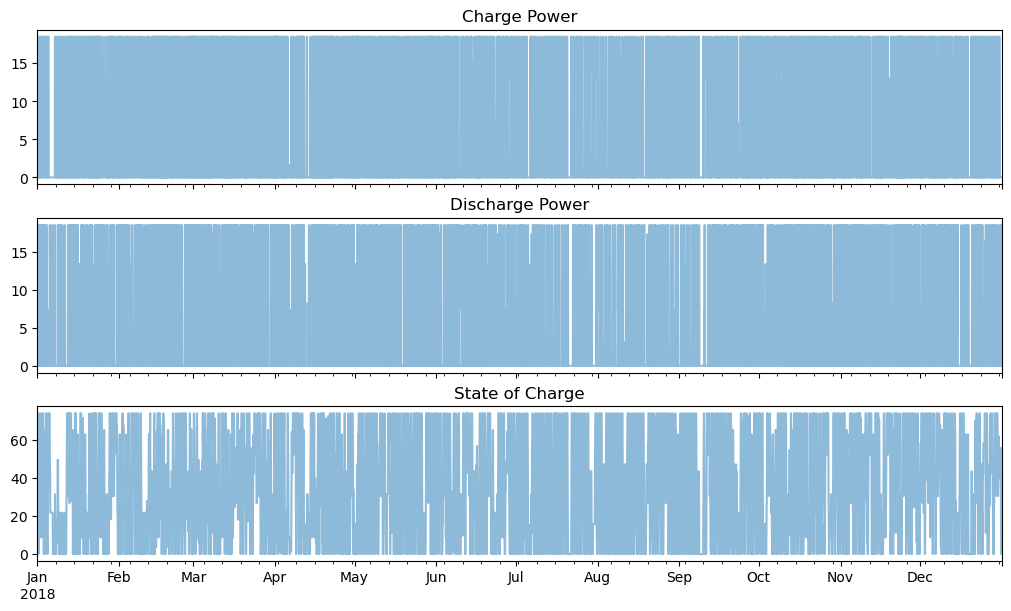

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10, 6),
                       sharex=True, layout='constrained')

results_0['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 1 w/o IC', alpha=0.5)
results_0['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 1 w/o IC', alpha=0.5)
results_0['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 1 w/o IC', alpha=0.5)

# results_1['esrPCrg'].iloc[:, ii].plot(ax=axs[0], label='Day 2 w/ IC', alpha=0.5)
# results_1['esrPDis'].iloc[:, ii].plot(ax=axs[1], label='Day 2 w/ IC', alpha=0.5)
# results_1['esrSOC'].iloc[:, ii].plot(ax=axs[2], label='Day 2 w/ IC', alpha=0.5)

titles = ['Charge Power', 'Discharge Power', 'State of Charge']
for i, ax in enumerate(axs):
    ax.set_title(titles[i])

### Thermal generation

In [ ]:
# Read thermal generator info table
filename = os.path.join(grid_data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i]
              for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [ ]:
# Format results
thermal_pg_0 = (results_0['PG'].iloc[:, :num_thermal]
                .rename(columns=gen_rename))

# thermal_pg_1 = (results_1['PG'].iloc[:, :num_thermal]
#                 .rename(columns=gen_rename))

In [ ]:
gen_info[gen_info['PTID'] == 23512]

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
7,Arthur Kill ST 2,23512,J,Steam Turbine,Natural Gas,40.5915,-74.2027,349.0,96.0,34.9,...,349.0,8.666516,252.390433,0.995837,0.000772,8.373115,274.28691,0.99586,1,10m


In [ ]:
def plot_gen(thermal_pg: pd.Series,
             gen_hist: pd.Series,
             gen_max: pd.Series,
             gen_min: pd.Series,
             ax: plt.Axes,
             title) -> plt.Axes:

    ax.plot(thermal_pg.index, thermal_pg,
            marker='^', label='OPF',
            linewidth=2, alpha=0.7, markersize=5)
    ax.plot(thermal_pg.index, gen_hist,
            marker='o', label='OPF MATLAB',
            linewidth=2, alpha=0.7, markersize=5)
    ax.plot(thermal_pg.index, gen_max,
            linestyle='--', label='max',
            linewidth=2, alpha=0.7, markersize=5)
    ax.plot(thermal_pg.index, gen_min,
            linestyle='--', label='min',
            linewidth=2, alpha=0.7, markersize=5)
    ax.legend()
    if title:
        ax.set_title(title)

    return ax

NYISOName            Astoria 5
PTID                     23518
Zone                         J
UnitType         Steam Turbine
FuelType            Fuel Oil 2
Latitude               40.7869
Longitude             -73.9122
maxPower                 776.0
minPower                   2.0
maxRampAgc                77.6
maxRamp10                776.0
maxRamp30                776.0
maxRamp60                776.0
HeatRateLM_1          4.411727
HeatRateLM_0        267.137351
HeatRateLM_R2         0.984701
HeatRateQM_2         -0.000037
HeatRateQM_1          4.439406
HeatRateQM_0        263.464135
HeatRateQM_R2         0.984698
useQM                        1
start-time                 10m
Name: 11, dtype: object

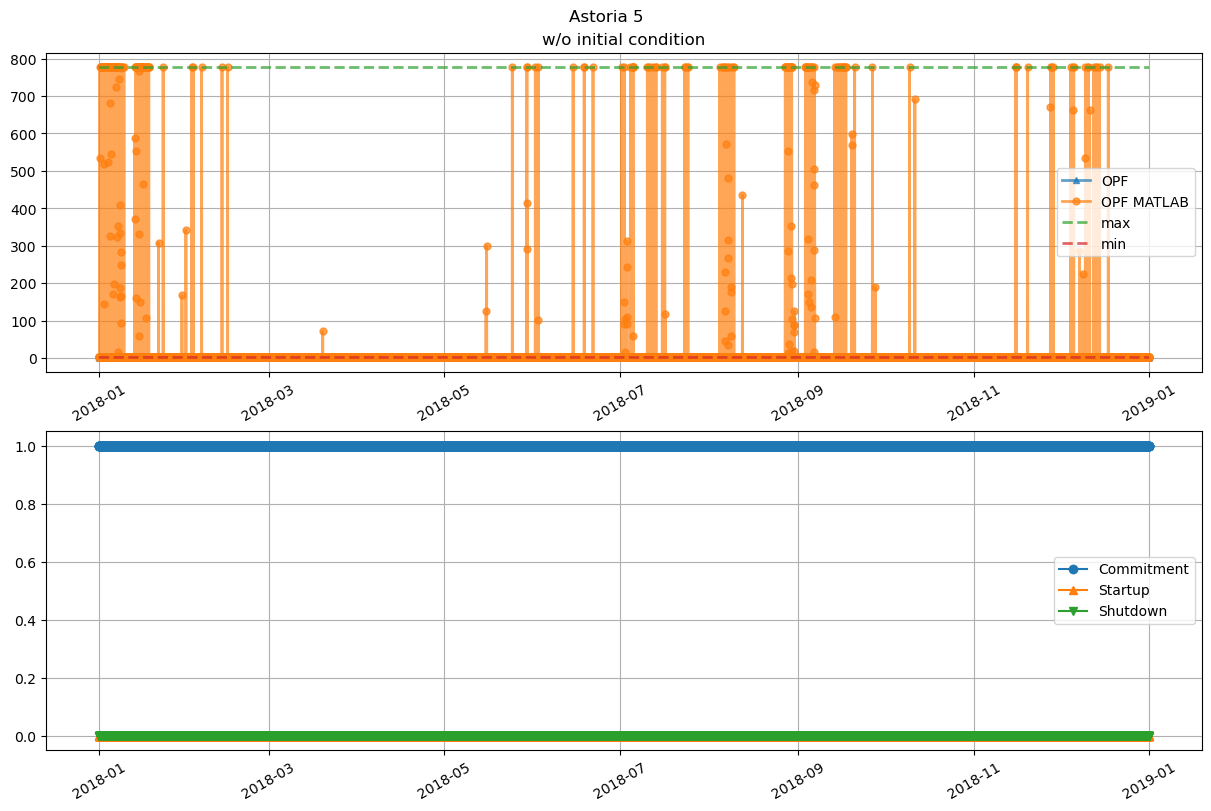

In [ ]:
ii = 11

display(gen_info.iloc[ii, :])

fig, axs = plt.subplots(2, 1, figsize=(12, 8), layout="constrained")

axs[0] = plot_gen(
    thermal_pg_0.iloc[:, ii],
    grid_profile["gen_profile"][start_datetime_0:end_datetime_0].iloc[:, ii],
    grid_profile["genmax_profile"][start_datetime_0:end_datetime_0].iloc[:, ii],
    grid_profile["genmin_profile"][start_datetime_0:end_datetime_0].iloc[:, ii],
    ax=axs[0],
    title="w/o initial condition",
)

axs[1].plot(results_0["genCommit"].iloc[:, ii], label="Commitment", marker="o")
axs[1].plot(results_0["genStartup"].iloc[:, ii], label="Startup", marker="^")
axs[1].plot(results_0["genShutdown"].iloc[:, ii], label="Shutdown", marker="v")
axs[1].legend()

# axs[2] = plot_gen(
#     thermal_pg_1.iloc[:, ii],
#     grid_profile["gen_profile"][start_datetime_1:end_datetime_1].iloc[:, ii],
#     grid_profile["genmax_profile"][start_datetime_1:end_datetime_1].iloc[:, ii],
#     grid_profile["genmin_profile"][start_datetime_1:end_datetime_1].iloc[:, ii],
#     ax=axs[2],
#     title="w/ initial condition",
# )

# axs[3].plot(results_1["genCommit"].iloc[:, ii], label="Commitment", marker="o")
# axs[3].plot(results_1["genStartup"].iloc[:, ii], label="Startup", marker="^")
# axs[3].plot(results_1["genShutdown"].iloc[:, ii], label="Shutdown", marker="v")
# axs[3].legend()

for ax in axs.flat:
    ax.tick_params(axis="x", rotation=30)
    ax.grid()

fig.suptitle(f"{gen_info.NYISOName[ii]}")
fig.show()